In [1]:
NOTEBOOKNAME = "미녕컴퓨터비전학습"

In [4]:
pip install tensorflow-addons

     |████████████████████████████████| 706kB 4.3MB/s 


In [5]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")
print(f"tfds.__version__: {tfds.__version__}")

tf.__version__: 2.4.1
tfa.__version__: 0.12.1
tfds.__version__: 4.0.1


In [6]:
from google.colab import auth, drive
from IPython.display import clear_output

try:
    drive.mount("/content/drive")
    auth.authenticate_user()
    clear_output()
    print("Done")
except:
    pass

Done


Experimental Environment
Google Colab Pro의 구성 환경입니다. 대략 아래와 같은 항목들이 사용되었음을 확인할 수 있습니다.

OS: Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
GPU: Tesla V100-SXM2-16GB
CPU: Intel(R) Xeon(R) CPU @ 2.00GHz
Memory: 25G
This is the configuration environment of Google Colab Pro. You can see that roughly the following items have been used.

OS: Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
GPU: Tesla V100-SXM2-16GB
CPU: Intel(R) Xeon(R) CPU @ 2.00GHz
Memory: 25G

In [7]:
# Memory
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        700M        9.9G        988K        2.1G         11G
Swap:            0B          0B          0B


In [8]:
# GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4826630742861852696
]


In [10]:
# OS
import platform
platform.platform()

'Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic'

In [11]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   33G   76G  30% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.9G     0  5.9G   0% /dev/shm
tmpfs           6.4G   24K  6.4G   1% /var/colab
/dev/sda1       114G   34G   81G  30% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  8.6G  6.5G  57% /content/drive


In [12]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

Load Dataset
데이터 세트를 Google Drive에서 Local(Colab 환경)로 가져옵니다.

Import the dataset from Google Drive to Local (Colab environment).

In [18]:
%%time
import os

# mkdir
save_data_path = "./data"
if not os.path.exists(save_data_path): 
    os.mkdir(save_data_path)

# copy train_answer.csv
!cp "/content/drive/MyDrive/캐글스터디/컴퓨터 비전학습/train.csv" "/content/drive/MyDrive/캐글스터디/컴퓨터 비전학습/data"
!cp "/content/drive/MyDrive/캐글스터디/컴퓨터 비전학습/test.csv" "/content/drive/MyDrive/캐글스터디/컴퓨터 비전학습/data"

CPU times: user 3.85 ms, sys: 21.6 ms, total: 25.5 ms
Wall time: 443 ms


In [19]:
ls -al "/content/drive/MyDrive/캐글스터디/컴퓨터 비전학습/data"

total 42955
-rw------- 1 root root 39981059 Feb 17 12:51 test.csv
-rw------- 1 root root  4004157 Feb 17 12:51 train.csv


#Generate Dataset
데이터 세트를 Train / Validation으로 분할합니다.

신경망의 주입값으로 사용하기 위한 적절한 전처리 과정들이 나열되어 있습니다.

Split the dataset into Train / Validation.

Appropriate preprocessing procedures for use as neural network injection values are listed.

train dataset을 생성하되, SEED를 기반으로 섞어줍니다.

Create a train dataset, but mix it based on SEED.

In [20]:
import pandas as pd
from sklearn.utils import shuffle

def get_tr_data(SEED):    
    tr_data = pd.read_csv("/content/drive/MyDrive/캐글스터디/컴퓨터 비전학습/data/train.csv", index_col = 0).values # index_col설정,후 value로 값을 가지고옴
    tr_data = shuffle(tr_data, random_state = SEED)

    tr_X = tf.convert_to_tensor(tr_data[:, 2:], dtype = tf.float32) # convert_to_tensor를 활용하여 텐서로 바꿔줌
    tr_Y = tf.squeeze(tf.convert_to_tensor(tr_data[:, 0], dtype = tf.int32))#tf.squeeze는 차원 중 사이즈가 1인 것을 찾아서 제거한다 ex)(2,2,1) -> (2,2)
#('https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221164750517&proxyReferer=https:%2F%2Fwww.google.com%2F')
    return tr_X, tr_Y


def get_ts_data():
    ts_data = pd.read_csv("/content/drive/MyDrive/캐글스터디/컴퓨터 비전학습/data/test.csv", index_col = 0).values
    ts_X = tf.convert_to_tensor(ts_data[:, 1:], dtype = tf.float32)

    return ts_X

(784) 사이즈의 flatten tensor를 (28, 28) 사이즈의 이미지로 변환한 뒤, (256, 256) 사이즈로 upsampling 합니다.

이후 값을 구간 [0, 1]로 맞추는 Normalize를 진행하여 줍니다.

아래 정의된 두 함수의 차이는 단순히 label의 유무입니다.

Convert a flatten tensor of (784) size to an image of (28, 28) size, and then upsamp it to size (256, 256).

After that, normalize the value to the interval [0, 1].

The difference between the two functions defined below is simply the presence or absence of a label.

In [15]:
IMAGE_SIZE = [28, 28]
RESIZED_IMAGE_SIZE = [256, 256]

@tf.function
def _reshape_and_resize_tr(flatten_tensor, label):
    image_tensor = tf.reshape(flatten_tensor, (*IMAGE_SIZE, 1))
    image_tensor = tf.keras.layers.experimental.preprocessing.Resizing(*RESIZED_IMAGE_SIZE)(image_tensor)
    image_tensor = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image_tensor)
    return image_tensor, label


@tf.function
def _reshape_and_resize_ts(flatten_tensor): # without label
    image_tensor = tf.reshape(flatten_tensor, (*IMAGE_SIZE, 1))
    image_tensor = tf.keras.layers.experimental.preprocessing.Resizing(*RESIZED_IMAGE_SIZE)(image_tensor)
    image_tensor = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image_tensor)
    return image_tensor

make_dataset() 함수는 단순히 type에 따라 적절한 데이터 세트를 생성하는 기능을 수행합니다.

make_fold() 함수는 5개의 dataset으로 이루어진 tr_datasets, vl_datasets를 반환합니다.

The make_dataset() function simply performs the function of creating an appropriate data set according to the type.

The make_fold() function returns tr_datasets and vl_datasets consisting of 5 datasets.

In [16]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

def print_shapes(l, l_name, end = False):
    assert type(l) is list

    print(f"len({l_name}) = {len(l)}")
    for i in range(len(l)):
        print(f"{l_name}[{i}]: {l[i]}")
    if not end:
        print()
    

def make_dataset(X, Y, type):
    if type == "train":
        assert X.shape[0] == Y.shape[0]
        dataset = tf.data.Dataset.from_tensor_slices((X, Y)
                            ).map(_reshape_and_resize_tr, num_parallel_calls = AUTO #apply같은 인자
                            ).cache(#똑같은 파일을 생성하는 인자/ 근데 왜사용했을까? 사용하지도 않을꺼면서 ;_;
                            ).shuffle(20000, reshuffle_each_iteration = True
                            ).batch(BATCH_SIZE
                            ).prefetch(AUTO)   

    elif type == "validation":
        assert X.shape[0] == Y.shape[0]
        dataset = tf.data.Dataset.from_tensor_slices((X, Y)
                            ).map(_reshape_and_resize_tr, num_parallel_calls = AUTO
                            ).cache(
                            # ).shuffle(20000, reshuffle_each_iteration = True
                            ).batch(BATCH_SIZE
                            ).prefetch(AUTO)

    elif type == "test":
        assert Y is None
        dataset = tf.data.Dataset.from_tensor_slices((X)
                            ).map(_reshape_and_resize_ts, num_parallel_calls = AUTO
                            ).cache(
                            # ).shuffle(20000, reshuffle_each_iteration = True
                            ).batch(BATCH_SIZE
                            ).prefetch(AUTO)
                            
    else:
        raise ValueError(f"Unknown type: {type}")

    return dataset


def make_fold(X, Y, K = 5):
    assert X.shape[0] == Y.shape[0]
    assert len(list(Y.shape)) == 1

    fold_size = [X.shape[0] // K] * (K - 1) + [X.shape[0] - (X.shape[0] // K) * (K - 1)]

    splited_X = tf.split(X, fold_size, 0) # list
    splited_Y = tf.split(Y, fold_size, 0) # list

    tr_list = [(tf.concat(splited_X[:i] + splited_X[i+1:], axis = 0), tf.concat(splited_Y[:i] + splited_Y[i+1:], axis = 0)) for i in range(K)]
    vl_list = [(splited_X[i], splited_Y[i]) for i in range(K)]

    tr_datasets = [make_dataset(tr_X, tr_Y, "train") for tr_X, tr_Y in tr_list]
    vl_datasets = [make_dataset(vl_X, vl_Y, "validation") for vl_X, vl_Y in vl_list]

    return tr_datasets, vl_datasets

#Show Examples
Upsampling 및 Augmentation 간 사용한 매개변수의 근거가 되는 라인입니다.

This is the line on which the parameters used between Upsampling and Augmentation are based.

(28, 28) 사이즈의 원본 이미지를 (64, 64), (128, 128), (256, 256) 사이즈로 해상도를 높였을 때 에러없이 잘 수행되는지 확인합니다.

눈으로 보았을 때 이상이 없으므로, (256, 256) 사이즈로 해상도를 높여도 문제가 없을 것 같습니다.

When the resolution of the original image of (28, 28) size is increased to (64, 64), (128, 128), (256, 256) size, check that it performs well without error.

There is nothing wrong with the eyes, so there seems to be no problem even if you increase the resolution to (256, 256) size.



In [22]:
# tr_data = pd.read_csv("/content/drive/MyDrive/캐글스터디/컴퓨터 비전학습/data/train.csv", index_col = 0).values
# # tr_data = shuffle(tr_data, random_state = SEED)

# tr_X = tf.convert_to_tensor(tr_data[:, 2:], dtype = tf.float32)
# tr_Y = tf.squeeze(tf.convert_to_tensor(tr_data[:, 0], dtype = tf.int32))
# # 왜 get_tr_data함수 만들어 놓고 안쓰냐?
get_tr_data(48)

(<tf.Tensor: shape=(2048, 784), dtype=float32, numpy=
 array([[3., 3., 4., ..., 0., 2., 1.],
        [4., 3., 3., ..., 4., 0., 0.],
        [0., 0., 3., ..., 0., 0., 1.],
        ...,
        [1., 2., 0., ..., 2., 1., 1.],
        [2., 2., 2., ..., 0., 1., 3.],
        [3., 1., 2., ..., 0., 4., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(2048,), dtype=int32, numpy=array([1, 7, 1, ..., 3, 5, 2], dtype=int32)>)

In [23]:
aa = tf.reshape(tr_X[318], (28, 28, 1))
result1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(aa)
result2 = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(aa)
result3 = tf.keras.layers.experimental.preprocessing.Resizing(256, 256)(aa)

answer = tr_Y[318]

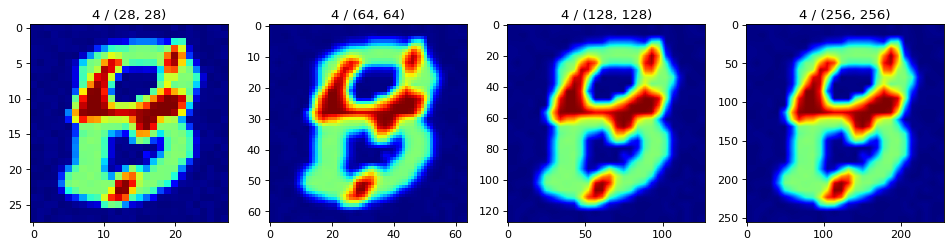

tf.Tensor(4, shape=(), dtype=int32)


In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize = (12, 4), dpi = 80)

for i, img in enumerate([aa, result1, result2, result3]):
    plt.subplot(1, 4, i + 1)
    plt.imshow(tf.squeeze(img), cmap = "jet")
    plt.title(f"{answer} / {tf.squeeze(img).shape}")
    
plt.tight_layout()
plt.show()
print(answer)

저는 데이터 증식은 무작정 데이터의 수를 늘리기만 해서는 되는것이 아니라, 해당 데이터가 갖는 중요한 정보를 잃지 않는 것이 가장 중요하다고 생각했습니다.

따라서 전체 데이터를 더해주었을 때, 그 값이 높은 부분(적색 부분)이 최대한 손상되지 않는 범위에서 zooming, shifting 및 rotating 등의 작업을 수행하는 것이 바람직한 접근방법일 것입니다.  (위의 사진에 숨겨져 있는 숫자는 4) 따라서 빨간 부분을 해치지 않고 데이터의 양을 늘려야함)


I thought that data proliferation is not just about increasing the number of data randomly, it is most important not to lose the important information that the data has.

Therefore, when the entire data is added, it would be a good approach to perform operations such as zooming, shifting, and rotating in a range that does not damage the part with the high value (red part) as much as possible.

먼저 training dataset을 다 더해준 값을 확인해줍니다.

First, check the added value of the training dataset.

In [26]:
aa = tf.reshape(tr_X, (-1, 28, 28, 1)) # reshape에서 -1을 넣은 자리는 나머지를 모두 할당하고 남는 수를 알아서 채워줌
result1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(aa)
result2 = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(aa)
result3 = tf.keras.layers.experimental.preprocessing.Resizing(256, 256)(aa)

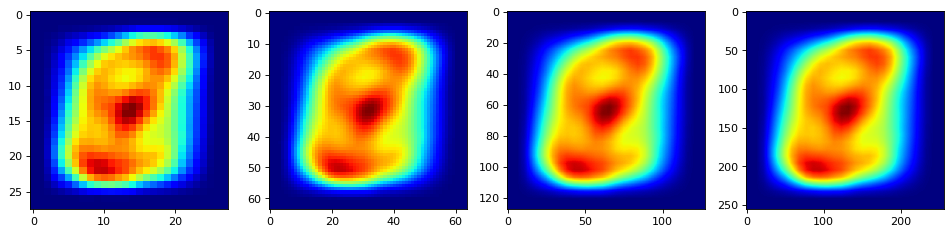

In [27]:
plt.figure(figsize = (12, 4), dpi = 80)

for i, img in enumerate([aa, result1, result2, result3]):
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(tf.squeeze(tf.math.reduce_sum(img, axis = 0)), cmap = "jet")
    # plt.title(f"{answer} / {tf.squeeze(img).shape}")
    
plt.tight_layout()
plt.show()

In [28]:
ts_data = pd.read_csv("/content/drive/MyDrive/캐글스터디/컴퓨터 비전학습/data/test.csv", index_col = 0).values
ts_X = tf.convert_to_tensor(ts_data[:, 1:], dtype = tf.float32)

In [29]:
aa = tf.reshape(ts_X, (-1, 28, 28, 1))
result1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(aa)
result2 = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(aa)
result3 = tf.keras.layers.experimental.preprocessing.Resizing(256, 256)(aa)

# answer = tr_Y

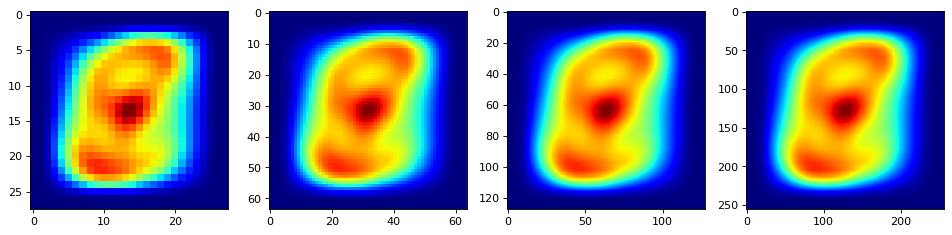

In [30]:
plt.figure(figsize = (12, 4), dpi = 80)

for i, img in enumerate([aa, result1, result2, result3]):
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(tf.squeeze(tf.math.reduce_sum(img, axis = 0)), cmap = "jet")
    # plt.title(f"{answer} / {tf.squeeze(img).shape}")
    
plt.tight_layout()
plt.show()

저는 데이터 증식에는 회전 및 확대/축소만 수행했습니다.

위의 실험 결과에 따라, 확대 범위는 매우 낮은 값인 0.1로 설정하게 되었습니다.

I only rotated and zoomed in data growth.

Based on the above experiment results, the magnification range was set to a very low value of 0.1.



#Build Model
신경망 구성 단계입니다.

직접 구현한 DenseNet-121 구조를 사용했으며, SpatialDropout 및 InceptionV3에서 사용되는 auxiliary output를 추가했습니다.

Auxiliary output으로부터 auxiliary loss가 생성되며, 이는 0.2의 가중치가 곱해져서 최종 loss에 가산됩니다.

테스트 단계에서는 해당 output이 사용되지 않습니다.

신경망 1개당 약 8.3M 개의 파라미터를 가집니다.

Neural network construction step.

I used the DenseNet-121 structure I implemented myself, and added auxiliary outputs used by SpatialDropout and InceptionV3.

An auxiliary loss is created from the auxiliary output, which is multiplied by a weight of 0.2 and added to the final loss.

The output is not used during the test phase.

Each neural network has about 8.3M parameters.

다른 유저분들과는 다르게, 저는 Softmax + Categorical Crossentropy 구조를 사용하지 않았습니다.

대신 activation function이 없는 dense를 거친 output을 L2 정규화하여 내보낸 뒤, Triplet Semi-Hard Loss Function을 이용하여 손실을 계산했습니다.

Triplet Loss Function은 3개의 feature를 비교하는 방식으로, anchor(기준 특징값)와 positive class (같은 클래스의 특징값) 사이의 거리는 가깝게 매핑합니다. 이와 동시에, anchor와 negative class (다른 클래스의 특징값) 사이의 거리는 멀게 매핑합니다.

Image에 대한 Embedding 기법이라고 생각하시면 좋을 것 같습니다.

해당 손실함수에 대한 추가적인 내용은 아래를 참고하여 주시기 바랍니다.

https://www.tensorflow.org/addons/tutorials/losses_triplet
https://arxiv.org/pdf/1503.03832.pdf
https://jsideas.net/ImageEmbeddingWithTripletLoss/
Unlike other users, I did not use the Softmax + Categorical Crossentropy structure.

Instead, the dense output without the activation function was normalized by L2 and exported, and then the loss was calculated using the Triplet Semi-Hard Loss Function.

Triplet Loss Function is a method of comparing three features, and the distance between anchor (reference feature value) and positive class (feature value of the same class) is closely mapped. At the same time, the distance between the anchor and the negative class (a feature value of another class) is mapped further.

It would be nice to think of it as an embedding technique for an image.

For more information on the loss function, please refer to the following.

https://www.tensorflow.org/addons/tutorials/losses_triplet
https://arxiv.org/pdf/1503.03832.pdf
https://jsideas.net/ImageEmbeddingWithTripletLoss/
해당 손실함수와 auxiliary loss를 사용할 경우, 손실 그래프는 대략 아래와 같이 표현됩니다.

When using the corresponding loss function and auxiliary loss, the loss graph is roughly expressed as follows.

In [ ]:
img1 = plt.imread('./123.png')

plt.figure(figsize=(12,12))
plt.imshow(img1)
plt.show()

특별히 해당 loss를 사용하는 이유는, 성능이 좋을 것을 확신해서가 아닙니다.

단지 기존에 주류를 이루는 방법과는 다른 저만의 방식으로도 충분히 좋은 성과를 낼 수 있음을 입증하기 위한 새로운 시도였습니다.

The reason for using this loss in particular is not because you are sure it will perform well.

It was just a new attempt to prove that I could do well enough in my own way, which is different from the existing mainstream methods.

In [ ]:
def bn_ReLU_conv2D(x, filters, kernel_size, 
                   strides = 1, padding = "same", weight_decay = 1e-4):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(
        filters = filters, 
        kernel_size = kernel_size, 
        strides = strides,
        padding = padding,
        kernel_regularizer = tf.keras.regularizers.l2(weight_decay))(x)
    
    return x


def transition_block(x):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(x.shape[-1] // 2, 1, padding = "same")(x)
    x = tf.keras.layers.AveragePooling2D((2, 2), strides = 2)(x)

    return x


def dense_block(x, num_conv, growth_rate):
    for i in range(num_conv):
        residual = x
        x = bn_ReLU_conv2D(x, 4 * growth_rate, 1)
        x = bn_ReLU_conv2D(x, growth_rate, 3)
        x = tf.keras.layers.Concatenate(axis = -1)([x, residual])

    return x

In [ ]:
def create_NN(model_name, dropout_rate = 0.3, growth_rate = 32):
    model_input = tf.keras.layers.Input((*RESIZED_IMAGE_SIZE, 1))

    ## Pre-processing
    x = tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.1), (-0.2, 0.1), fill_mode = "constant")(model_input)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, fill_mode = "constant")(x)

    ## Entry Flow
    x = tf.keras.layers.Conv2D(2 * growth_rate, 7, strides = 2, padding = "same")(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides = 2, padding = "same")(x)


    ## Middle Flow
    aux_outputs = []
    for i, num_conv in enumerate([6, 12, 24, 16]):
        x = dense_block(x, num_conv, growth_rate)

        if i is not 3: 
            x = transition_block(x)
            x = tf.keras.layers.SpatialDropout2D(dropout_rate)(x)

        if i == 2:
            y = tf.keras.layers.GlobalAveragePooling2D()(x)
            y = tf.keras.layers.Dense(y.shape[-1])(y)
            y = tf.keras.layers.Lambda(lambda y: tf.math.l2_normalize(y, axis = 1), name = "aux")(y) # L2 normalize embeddings
            aux_outputs.append(y)


    ## Exit Flow
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(x.shape[-1])(x)
    real_output = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis = 1), name = "real")(x) # L2 normalize embeddings

    model = tf.keras.Model(
        inputs = model_input,
        outputs = aux_outputs + [real_output],
        name = model_name)
    
    return model

In [ ]:
tmp_model = create_NN("tmp_model")
tmp_model.summary()

In [ ]:
tf.keras.utils.plot_model(tmp_model, show_shapes = True, show_layer_names = False)

In [ ]:
del tmp_model

#Compile and Train
매번 새로운 옵티마이저, 콜백 함수를 호출하기 위해서 함수로 구현한 부분입니다.

This is the part implemented as a function to call a new optimizer and callback function every time.

optimizer 함수는 Rectified Adam을 사용했으며, Lookahead Wrapper를 추가해주었습니다.

특별히 Lookahead Wrapper는 "월간 데이콘 5: 생체 광학 데이터 분석 AI 경진대회"에서 1위를 수상하신 SF 님께서도 사용하셨기 때문에, 관심을 갖고 찾아보고 실험하였습니다.

https://dacon.io/competitions/official/235608/codeshare/1274?page=2&dtype=recent&ptype=pub
Rectified Adam was used as the optimizer function, and a Lookahead Wrapper was added.

In particular, Lookahead Wrapper was used by SF, who won first place in the "Monthly Daycon 5: Bio-Optical Data Analysis AI Contest", so we looked up and experimented with interest.

https://dacon.io/competitions/official/235608/codeshare/1274?page=2&dtype=recent&ptype=pub
Droout Rate, Growth Rate, Optimizer는 각각 0.3, 32, Rectified Adam을 사용하였으며, 해당 근거는 아래 표와 같습니다.

Droout Rate, Growth Rate, and Optimizer used 0.3, 32, and Rectified Adam, respectively, and the basis for this is shown in the table below.

(growth_rate == 40일 경우는 ResourceExhauseError 때문에 수행하지 못했습니다.)

(In case of growth_rate == 40, it could not be executed because of ResourceExhauseError.)

Dropout = 0.3
growth_rate	optimizer	val_loss
12	Adam	0.38935
12	AdamW	0.34652
12	Rectified Adam	0.35595
12	RMSprop	0.55919
24	Adam	0.37023
24	AdamW	0.36667
24	Rectified Adam	0.31322
24	RMSprop	0.46081
32	Adam	0.46318
32	AdamW	0.31881
32	Rectified Adam	0.31315
32	RMSprop	0.43235
Dropout = 0.4
growth_rate	optimizer	val_loss
12	Adam	0.35099
12	AdamW	0.45077
12	Rectified Adam	0.37492
12	RMSprop	0.46896
24	Adam	0.45740
24	AdamW	0.34025
24	Rectified Adam	0.31850
24	RMSprop	0.43569
32	Adam	0.43407
32	AdamW	0.33302
32	Rectified Adam	0.33354
32	RMSprop	0.44503
Dropout = 0.5
growth_rate	optimizer	val_loss
12	Adam	0.51993
12	AdamW	0.49499
12	Rectified Adam	0.39148
12	RMSprop	0.62542
24	Adam	0.43550
24	AdamW	0.36983
24	Rectified Adam	0.31850
24	RMSprop	0.58344
32	Adam	0.40553
32	AdamW	0.41680
32	Rectified Adam	0.37814
32	RMSprop	0.51033
가장 성능이 좋았던 모델은, (dropout_rate, growth_rate, optimizer)가 (0.3, 32, Rectified Adam)일 경우였으며, 해당 인자를 그대로 사용했습니다.

The model with the best performance was when (dropout_rate, growth_rate, optimizer) was (0.3, 32, Rectified Adam), and the parameters were used as they were.

In [ ]:
def get_opt(init_lr = 3e-3):
    radam = tfa.optimizers.RectifiedAdam(
        lr = init_lr, warmup_proportion = 0, min_lr = 1e-5, weight_decay = 1e-4)
    ranger = tfa.optimizers.Lookahead(radam)

    return ranger

Colab의 최대 Runtime은 12시간이므로, 모든 fold에서 생성된 checkpoint는 google cloud platform에 저장됩니다.

Colab's maximum runtime is 12 hours, so checkpoints created in every fold are stored in google cloud platform.

In [ ]:
# Define callbacks
def scheduler(epoch, lr):
    # lr = 0.96 * lr for every 4 epochs
    if not epoch:
        return lr
    elif not (epoch % 4):
        return 0.96 * lr
    else:
        return lr


def get_callbacks(GCS_PATH, model_name):
    # reduce learning rate callback
    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

    # checkpoint callback
    checkpoint_path = os.path.join(
        GCS_PATH, "ckpt", NOTEBOOKNAME, model_name, "cp-{epoch:03d}-{val_real_loss:.4f}.ckpt")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose = 2, monitor = "val_real_loss",
        save_weights_only = True, save_best_only = True)

    return [lr_callback, cp_callback]

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

def draw_history(history):
    plt.figure(figsize = (8, 6), facecolor = "white", dpi = 80)

    plt.plot(history.epoch, history.history["aux_loss"], "rx-", label = "aux_loss", alpha = 0.5)
    plt.plot(history.epoch, history.history["val_aux_loss"], "bx-", label = "val_aux_loss", alpha = 0.5)
    plt.plot(history.epoch, history.history["real_loss"], "ro-", label = "real_loss")
    plt.plot(history.epoch, history.history["val_real_loss"], "bo-", label = "val_real_loss")

    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

5-Fold Cross Validation을 수행하되, SEED에 따라 dataset을 섞음으로써 매번 다른 train / validation 쌍이 나올 수 있도록 합니다.

총 5번 반복하였으므로, 25개의 sub-model이 생성됩니다.

코드 실행결과는 너무 길어서 생략하였습니다.

Perform 5-Fold Cross Validation, but mix the dataset according to SEED so that different train/validation pairs can appear each time.

Since it was repeated 5 times, 25 sub-models are created.

The code execution result was too long to be omitted.

Try 0: N = 0, SEED = 1234

In [ ]:
tr_X, tr_Y = get_tr_data(SEED = 1234)

print(f"tr_X.shape: {tr_X.shape}, dtype: {tr_X.dtype}")
print(f"tr_Y.shape: {tr_Y.shape}, dtype: {tr_Y.dtype}")

In [ ]:
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Print the shapes.
print_shapes(tr_datasets, "tr_datasets")
print_shapes(vl_datasets, "vl_datasets", end = True)

In [ ]:
N = 0
K = 5
GCS_PATH = "gs://dacon-7-emnist"

histories = []
for fold in range(K):
    model = create_NN(f"model_{N}_{fold}")

    model.compile(
        optimizer = get_opt(),
        loss = tfa.losses.TripletSemiHardLoss(),
        loss_weights = [0.2, 1.0])
    
    history = model.fit(
        tr_datasets[fold], validation_data = vl_datasets[fold], epochs = 400, verbose = 2,
        callbacks = get_callbacks(GCS_PATH, model.name))

    histories.append(history)
    
    del model

In [ ]:
draw_history(histories)

Try 1: N = 1, SEED = 2345

In [ ]:
tr_X, tr_Y = get_tr_data(SEED = 2345)

print(f"tr_X.shape: {tr_X.shape}, dtype: {tr_X.dtype}")
print(f"tr_Y.shape: {tr_Y.shape}, dtype: {tr_Y.dtype}")

In [ ]:
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Print the shapes.
print_shapes(tr_datasets, "tr_datasets")
print_shapes(vl_datasets, "vl_datasets", end = True)

In [ ]:
N = 1
K = 5
GCS_PATH = "gs://dacon-7-emnist"

histories = []
for fold in range(K):
    model = create_NN(f"model_{N}_{fold}")

    model.compile(
        optimizer = get_opt(),
        loss = tfa.losses.TripletSemiHardLoss(),
        loss_weights = [0.2, 1.0])
    
    history = model.fit(
        tr_datasets[fold], validation_data = vl_datasets[fold], epochs = 400, verbose = 2,
        callbacks = get_callbacks(GCS_PATH, model.name))

    histories.append(history)
    
    del model

In [ ]:
draw_history(histories)

Try 2: N = 2, SEED = 3456

In [ ]:
tr_X, tr_Y = get_tr_data(SEED = 3456)

print(f"tr_X.shape: {tr_X.shape}, dtype: {tr_X.dtype}")
print(f"tr_Y.shape: {tr_Y.shape}, dtype: {tr_Y.dtype}")

In [ ]:
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Print the shapes.
print_shapes(tr_datasets, "tr_datasets")
print_shapes(vl_datasets, "vl_datasets", end = True)

In [ ]:
N = 2
K = 5
GCS_PATH = "gs://dacon-7-emnist"

histories = []
for fold in range(K):
    model = create_NN(f"model_{N}_{fold}")

    model.compile(
        optimizer = get_opt(),
        loss = tfa.losses.TripletSemiHardLoss(),
        loss_weights = [0.2, 1.0])
    
    history = model.fit(
        tr_datasets[fold], validation_data = vl_datasets[fold], epochs = 400, verbose = 2,
        callbacks = get_callbacks(GCS_PATH, model.name))

    histories.append(history)
    
    del model

In [ ]:
draw_history(histories)

Try 3: N = 3, SEED = 4567

In [ ]:
tr_X, tr_Y = get_tr_data(SEED = 4567)

print(f"tr_X.shape: {tr_X.shape}, dtype: {tr_X.dtype}")
print(f"tr_Y.shape: {tr_Y.shape}, dtype: {tr_Y.dtype}")

In [ ]:
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Print the shapes.
print_shapes(tr_datasets, "tr_datasets")
print_shapes(vl_datasets, "vl_datasets", end = True)

In [ ]:
N = 3
K = 5
GCS_PATH = "gs://dacon-7-emnist"

histories = []
for fold in range(K):
    model = create_NN(f"model_{N}_{fold}")

    model.compile(
        optimizer = get_opt(),
        loss = tfa.losses.TripletSemiHardLoss(),
        loss_weights = [0.2, 1.0])
    
    history = model.fit(
        tr_datasets[fold], validation_data = vl_datasets[fold], epochs = 400, verbose = 2,
        callbacks = get_callbacks(GCS_PATH, model.name))

    histories.append(history)
    
    del model

In [ ]:
for history in histories:
    draw_history(history)

Try 4: N = 4, SEED = 5678

In [ ]:
tr_X, tr_Y = get_tr_data(SEED = 5678)

print(f"tr_X.shape: {tr_X.shape}, dtype: {tr_X.dtype}")
print(f"tr_Y.shape: {tr_Y.shape}, dtype: {tr_Y.dtype}")

In [ ]:
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Print the shapes.
print_shapes(tr_datasets, "tr_datasets")
print_shapes(vl_datasets, "vl_datasets", end = True)

In [ ]:
N = 4
K = 5
GCS_PATH = "gs://dacon-7-emnist"

histories = []
for fold in range(K):
    model = create_NN(f"model_{N}_{fold}")

    model.compile(
        optimizer = get_opt(),
        loss = tfa.losses.TripletSemiHardLoss(),
        loss_weights = [0.2, 1.0])
    
    history = model.fit(
        tr_datasets[fold], validation_data = vl_datasets[fold], epochs = 400, verbose = 2,
        callbacks = get_callbacks(GCS_PATH, model.name))

    histories.append(history)
    
    del model

In [ ]:
for history in histories:
    draw_history(history)

Load Latest Models
생성된 25개의 sub-model을 호출합니다.

Call the created 25 sub-models.

In [ ]:
%%time
num_N = 5
K = 5
GCS_PATH = "gs://dacon-7-emnist"

models = []

for n in range(num_N):
    for fold in range(K):
        model = create_NN(f"model_{n}_{fold}")

        checkpoint_dir = os.path.join(GCS_PATH, "ckpt", NOTEBOOKNAME, model.name)
        latest = tf.train.latest_checkpoint(checkpoint_dir)

        model.load_weights(latest)
        models.append(model)
        
        print(f"Try #{n}, Fold #{fold}: {latest}")

Generate Enrollment Templates
각 신경망에 대한 validation dataset의 output을 산출합니다.

해당 결괏값들의 클래스별 평균이 곧 해당 클래스를 대표하는 "대표값(enrollment template)"이 됩니다.

앞서 모델 생성 간, auxiliary output을 추가하였다고 말씀드렸습니다. 실제로 모델 output을 받을 경우에는, 길이 512짜리 aux output과 1024짜리 real output이 리스트(list)에 담겨서 나옵니다. 우리가 원하는 값은 real output이므로, 2번째 값만 사용합니다.

Calculate the output of the validation dataset for each neural network.

The average of the result values by class becomes the "enrollment template" representing the class.

I mentioned earlier that during model creation, auxiliary outputs were added. In case of receiving model output, aux output of length 512 and real output of 1024 are included in the list. The value we want is a real output, so we only use the second value.

In [ ]:
# Example Code
tr_X, tr_Y = get_tr_data(1234)
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

aux, real = models[0].predict(vl_datasets[0])
print(f"aux_shape: {aux.shape}")
print(f"real_shape: {real.shape}")

In [ ]:
%%time
results = []
seeds = [1234, 2345, 3456, 4567, 5678]

for n in range(num_N):
    tr_X, tr_Y = get_tr_data(SEED = seeds[n])
    tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

    for fold in range(K):
        result = models[n * 5 + fold].predict(vl_datasets[fold])[-1]
        results.append(result)

        print(f"results[{n * 5 + fold}].shape: {result.shape}")

Embedding Visualization
U-Map으로 Embedding한 결과를 보여줍니다.

It shows the result of Embedding with U-Map.

In [ ]:
# Example Code
import io
import numpy as np

tr_X, tr_Y = get_tr_data(1234)
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Save test embeddings for visualization in projector
# https://projector.tensorflow.org/
np.savetxt("vecs.tsv", results[0], delimiter = "\t")

out_m = io.open("meta.tsv", "w", encoding = "utf-8")
for img, labels in tfds.as_numpy(vl_datasets[0]):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

try:
    from google.colab import files
    files.download("vecs.tsv")
    files.download("meta.tsv")
except:
    pass

In [ ]:
from matplotlib import pyplot as plt
img1 = plt.imread('./1234.png')

plt.figure(figsize=(12,12))
plt.imshow(img1)
plt.show()

10개의 클래스 각각에 대한 길이 1024짜리 특징 벡터를 생성합니다.

Create a 1024-length feature vector for each of the 10 classes.

In [ ]:
%%time
import numpy as np

enrollment_templates = []

for n in range(num_N):
    tr_X, tr_Y = get_tr_data(SEED = seeds[n])
    tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

    for fold in range(K):
        vl_labels_list = []

        for _, labels in tfds.as_numpy(vl_datasets[fold]):
            vl_labels_list.append(labels)
        
        vl_labels = tf.concat(vl_labels_list, axis = 0)

        enrollment_template = np.array(
            [np.average(results[n * 5 + fold][vl_labels.numpy() == i], axis = 0) for i in range(10)])

        enrollment_templates.append(enrollment_template)
        print(f"enrollment_templates[{n * 5 + fold}].shape: {enrollment_template.shape}")

Predict Test Dataset
테스트 데이터 셋의 클래스를 결정하는 방법은, 해당 feature와의 유사도가 가장 높은 대표값을 찾으면 됩니다.

이때 "가장 유사하다"의 정의는 "L2 거리(유클리디언 거리)"이지만, 필요에 따라 Cosine Similarity, L1 Distance, Pearson Cross Correlation 등도 사용될 수 있습니다.

다만 Triplet Loss 내부에서 거리함수가 L2로 정의되어 있기 때문에, L2를 사용하였습니다.

The method of determining the class of the test data set is to find the representative value with the highest similarity to the feature.

Here, the definition of "most similar" is "L2 distance (Euclidean distance)", but Cosine Similarity, L1 Distance, Pearson Cross Correlation, etc. can also be used if necessary.

However, since the distance function is defined as L2 inside the Triplet Loss, L2 was used.

In [ ]:
ts_X = get_ts_data()
ts_dataset = make_dataset(ts_X, None, "test")
print(f"ts_dataset: {ts_dataset}")

In [ ]:
%%time
features = []

for n in range(num_N):
    for fold in range(K):
        feature = models[n * 5 + fold].predict(ts_dataset)[-1]
        features.append(feature)
        
        print(f"features[{n * 5 + fold}].shape: {feature.shape}")

Calculate Each Predictions based on Euclidena Distance
L2 거리를 계산하는 함수 l2_dist()를 선언하고, test dataset의 각 feature마다 10개의 모든 클래스의 enrollment template 사이의 거리를 계산합니다.

이때 결괏값을 모으는 방법에 대해 3가지를 실험해 보았습니다.

각 sub-model마다 test dataset에 대한 클래스를 결정 후 Voting (가장 많은 투표를 받은 클래스를 최종 선정)
각 sub-model마다 계산된 거리를 모두 더해주고, 그 값이 가장 낮은 클래스를 최종 선정
각 sub-model마다 계산된 거리를 "정규화 한 뒤" 모두 더해주고, 그 값이 가장 낮은 클래스를 최종 선정
결과적으로는 3번이 가장 좋았습니다. 어떤 클래스가 "얼만큼" 유사도가 높았는지에 대한 세밀한 계산이 보다 준수한 실험 결과로 이어진 것 같습니다.

We declare a function l2_dist() that calculates the L2 distance, and calculate the distance between the enrollment templates of all 10 classes for each feature in the test dataset.

At this time, I experimented with three methods of collecting the results.

Voting after determining the class for the test dataset for each sub-model (final selection of the class that received the most votes)
Add all the calculated distances for each sub-model, and finally select the class with the lowest value.
After "normalizing" the calculated distance for each sub-model, add them all, and finally select the class with the lowest value.
As a result, number 2 was the best. The detailed calculation of which classes were "how much" similarity seems to have led to more thorough experimental results.

In [ ]:
%%time
def l2_dist(A, B):
    return np.linalg.norm(A - B)

l2_distances = []

for n in range(num_N):
    for fold in range(K):
        l2_distance = np.array([[l2_dist(feature, e) for e in enrollment_templates[n * 5 + fold]] for feature in features[n * 5 + fold]])
        l2_distances.append(l2_distance / np.expand_dims(np.sum(l2_distance, axis = 1), 1))
        
        print(f"l2_distances[{n * 5 + fold}].shape: {l2_distance.shape}")

In [ ]:
# Show the distances -> seems to be class 6 (mininum class)
l2_distances[0][0] 

In [ ]:
l2_distances = np.array(l2_distances)
print(l2_distances.shape)

In [ ]:
l2_distances = np.sum(l2_distances, axis = 0)
l2_pred = np.expand_dims(np.argmin(l2_distances, axis = -1), axis = -1)
print(l2_pred.shape)

Make Submission

In [ ]:
import pandas as pd

# to csv
submission = pd.read_csv("/content/drive/My Drive/dacon/컴퓨터 비전 학습 경진대회/data/submission.csv", index_col = 0)
submission.loc[:, :] = l2_pred
submission.to_csv(f"/content/drive/My Drive/dacon/컴퓨터 비전 학습 경진대회/try122_submission.csv")

Result
Public LB Score: 0.95098 (rank 9)

Private LB Score: 0.93889 (rank 1)